In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from  matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import seaborn as sn
import sys
from pathlib import Path
from tqdm import tqdm
import scipy
import os

import torch.nn as nn
from torch import Tensor
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from scipy.stats import wasserstein_distance
from sklearn.metrics import roc_auc_score as roc_auc_score
from scipy.special import kl_div as kl_div
from sklearn.metrics import log_loss as log_loss
from torchmetrics.classification import BinaryCalibrationError

# import custom functions from src folder
module_path = str(Path.cwd() / "../src")

if module_path not in sys.path:
    sys.path.append(module_path)

from SequentialNet import SequentialNet
from machine_learning import *
from util import *

In [27]:
def word_to_int(df):
    # Red = 0, blue = 1
    df["class"] = 0
    df_copy = df.copy()
    mask = df_copy["color"] == "blue"
    df.loc[mask, "class"] = 1
    return df


In [28]:
def predict_grid(model, x1_key, x2_key, device, mcdropout:bool = False, nx:int = 100, n_MC:int = 100):
    x1_lim = 25
    x2_lim = 25
    x1 = np.linspace(-x1_lim, x1_lim, nx)
    x2 = np.linspace(-x2_lim, x2_lim, nx)
    xx1, xx2 = np.meshgrid(x1, x2)
    df = pd.DataFrame(columns = ["x1", "x2"], index = range(len(xx1.flatten())))
    df["x1"] = xx1.flatten()
    df["x2"] = xx2.flatten()
    df = cartesian_to_polar_df(df, "x1", "x2", "r_x", "a_x")

    X_gridtest = torch.Tensor(np.dstack((df[x1_key], df[x2_key]))).to(torch.float32)[0]
    Y_gridtest = torch.zeros(X_gridtest.shape)
    gridtest_dataset = torch.utils.data.TensorDataset(X_gridtest, Y_gridtest)
    if mcdropout:
        mean_val, variance_val = mc_predictions(model, gridtest_dataset, 2**8, n_MC, 2, len(df), )
        #Get average softmax score for blue
        df["Confidence_MC"] = mean_val[:,-1]
        df["Prediction_MC"] = np.argmax(mean_val, axis=-1).flatten()
        # Error is the same for both scores
        df["Std_MC"] = np.sqrt(variance_val[:,1])
    else:
        truth, logits = predict_classifier(model, gridtest_dataset, 2, 100, device)
        preds = torch.argmax(logits, dim=-1).flatten()
        df["Prediction"] = preds
        #Get softmax score for red
        df["Confidence"] = torch.softmax(logits, dim=-1)[:,1]
    return df

In [29]:
def predict_MCD(model, df, test_dataset, device, n_MC:int = 100):
     # Predict with just model
    df_new = df.copy()
    truth, logits = predict_classifier(model, test_dataset, 2, 100, device)
    preds = torch.argmax(logits, dim=-1).flatten()
    df_new["Prediction"] = preds
    df_new["Truth"] = truth

    #Get softmax score for blue
    df_new["Confidence"] = torch.softmax(logits, dim=-1)[:,1]

    # Predict with MC dropout
    mean_val, variance_val = mc_predictions(model, test_dataset, 2**8, n_MC, 2, len(test_dataset))
    df_new["Prediction_MC"] = np.argmax(mean_val, axis=-1).flatten()
    df_new["Confidence_MC"] = mean_val[:,-1]
    # Error is the same for both scores
    df_new["Std_MC"] = np.sqrt(variance_val[:,0])
    return df_new

In [30]:
# Set up device
device = (
    "cuda:0"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device {torch.cuda.get_device_name(0)}")

Using cuda:0 device NVIDIA TITAN V


In [34]:
# Machine learning options
x1_key = "x1"
x2_key = "x2"
#n_data = [10, 50]
patience = 150
load_values = False

#Data constants
R2 = 3
k_red = 7
k_blue = 3
R1_min = 6
scale = 1
vary_a1 = False
vary_R2 = False
p_red = 0.5
polar = False
tag = f'r2_{R2}_kr{k_red}_kb{k_blue}_r1min{R1_min}_s{scale}_vary_r2_{vary_R2}_vary_a1_{vary_a1}_pRed_{p_red}'

# Read files
train_n = 50000
trainfile = f"train_n_{train_n}_{tag}"
valfile = f"val_n_5000_{tag}"
testfile = f"test_n_10000_{tag}"
truthfile = f"analytical_solution_x1_x2_grid_{tag}_nr1MC_4000"
truthfile_test = "analytical_solution_test_n_10000_r2_3_kr7_kb3_r1min6_s1_vary_r2_False_vary_a1_False_pRed_0.5_nr1MC_8000"
gridfile = f"x1_x2_grid"

train_data = pd.read_csv(f"../data/{trainfile}.csv")
val_data = pd.read_csv(f"../data/{valfile}.csv")
test_data = pd.read_csv(f"../data/{testfile}.csv")
truth_data = pd.read_csv(f"../analytical/results/{truthfile}.csv")
truth_data = truth_data[truth_data["r_x"] > R1_min-R2] # Remove undefined area
truth_test_data = pd.read_csv(f"../analytical/results/{truthfile_test}.csv")
grid_data = pd.read_csv(f"../data/{gridfile}.csv")


#Correct analytical solution if class distribution is not equal
if p_red != 0.5:
    truth_data["P_red_and_x"] = truth_data["P_red_and_x"]*(p_red)/0.5
    truth_data["P_blue_and_x"] = truth_data["P_blue_and_x"]*(1-p_red)/0.5
    truth_data["P_x"] = truth_data["P_red_and_x"] + truth_data["P_blue_and_x"]
    truth_data["P_red_given_x"] = truth_data["P_red_and_x"]/truth_data["P_x"]
    truth_data["P_blue_given_x"] = truth_data["P_blue_and_x"]/truth_data["P_x"]

# Prepare data for pytorch
train_data = word_to_int(train_data)
val_data = word_to_int(val_data)
test_data = word_to_int(test_data)

X_train = torch.Tensor(np.dstack((train_data[x1_key], train_data[x2_key]))).to(torch.float32)[0]
Y_train = label_maker(train_data["class"], 2)

X_val = torch.Tensor(np.dstack((val_data[x1_key], val_data[x2_key]))).to(torch.float32)[0]
Y_val = label_maker(val_data["class"], 2)

X_test = torch.Tensor(np.dstack((test_data[x1_key], test_data[x2_key]))).to(torch.float32)[0]
Y_test = torch.zeros(X_test.shape)

X_grid = torch.Tensor(np.dstack((grid_data[x1_key], grid_data[x2_key]))).to(torch.float32)[0]
Y_grid = torch.zeros(X_grid.shape)

In [32]:
# Create datasets for pytorch
train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, Y_val)
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)
grid_dataset = torch.utils.data.TensorDataset(X_grid, Y_grid)

### Increasing number of datapoints

In [36]:
drop_out_rate = 0.3
n_MC=100
#n_data = [250, 500, 1000, 5000, 10000]
n_data = [2000, 3000]
max_err_val = [0]*len(n_data)
for i in range(len(n_data)):
    if n_data[i] < 1000:
        max_err_val[i] = 0.5
    else:
        max_err_val[i] = 0.25

test_dfs = [0]*len(n_data)
grid_dfs = [0]*len(n_data)

val_df = pd.read_csv(f"../data/{valfile}.csv")
test_df = pd.read_csv(f"../data/{testfile}.csv")
grid_df = pd.read_csv(f"../data/{gridfile}.csv")

if load_values==False:
    for i in range(len(n_data)):
        logloss_min = 1
        for j in tqdm(range(20)):
            # Create datasets for pytorch
            train_dataset = torch.utils.data.TensorDataset(X_train[0:n_data[i]], Y_train[0:n_data[i]])

            # Create model
            model = SequentialNet(L=1024*2, n_hidden=5, activation="relu", in_channels=2, out_channels=2, p=drop_out_rate).to(device)
            optimizer = optim.Adam(model.parameters(), lr=0.001)

            # Train model
            training_results = train_classifier(model, train_dataset, 
                                    test_dataset, batchsize=2**10, epochs = 250, 
                                    device = device, optimizer = optimizer, early_stopping=patience)
            # Predict on val set
            val_df = predict_MCD(model, val_df, val_dataset, device, n_MC=20)
            ll = log_loss(val_df["class"], val_df["Confidence_MC"])
            preds = torch.Tensor(val_df["Confidence_MC"])
            target = torch.Tensor(val_df["class"])
            bce_l1 = BinaryCalibrationError(n_bins=15, norm='l1')
            ece = bce_l1(preds, target).item()
            print(f"n_train = {n_data[i]}, logloss={ll}, ECE= {ece}")

            if ll < logloss_min:
                print(f"New best values: n_train = {n_data[i]}, logloss={ll}, ECE= {ece}")
                logloss_min = ll
                # Predict
                test_dfs[i] = predict_MCD(model, test_df, test_dataset, device, n_MC=n_MC)
                grid_dfs[i] = predict_MCD(model, grid_df, grid_dataset, device, n_MC=n_MC)

        # Save prediction
        if (not os.path.isdir(f"predictions/{trainfile}") ):
            os.mkdir(f"predictions/{trainfile}")
        test_dfs[i].to_csv(f"predictions/{trainfile}/{testfile}_predicted_SequentialNet_MCD_pd{drop_out_rate}_nMC_{n_MC}_Vndata-{n_data[i]}.csv")
        grid_dfs[i].to_csv(f"predictions/{trainfile}/grid_{tag}_predicted_SequentialNet_MCD_pd{drop_out_rate}_nMC_{n_MC}_Vndata-{n_data[i]}.csv")
else:
    for i in range(len(n_data)):
    #val_data_ensembles = [pd.read_csv(f"predictions/{trainfile}/{valfile}_predicted_SequentialNet_{n_ensemble}ensembles_ndata-{n_data[i]}.csv") for i in range(len(n_data))]
        test_dfs[i] = pd.read_csv(f"predictions/{trainfile}/{testfile}_predicted_SequentialNet_MCD_pd{drop_out_rate}_nMC_{n_MC}_Vndata-{n_data[i]}.csv")
        grid_dfs[i] = pd.read_csv(f"predictions/{trainfile}/grid_{tag}_predicted_SequentialNet_MCD_pd{drop_out_rate}_nMC_{n_MC}_Vndata-{n_data[i]}.csv")


  0%|          | 0/20 [00:00<?, ?it/s]

 64%|██████▎   | 159/250 [00:56<00:32,  2.80it/s]


Stopping training early at epoch 159


100%|██████████| 50/50 [00:00<00:00, 450.95it/s]


Starting MC dropout inference: 


100%|██████████| 20/20 [00:01<00:00, 11.84it/s]


n_train = 2000, logloss=0.5278721444208815, ECE= 0.050249021500349045
New best values: n_train = 2000, logloss=0.5278721444208815, ECE= 0.050249021500349045


100%|██████████| 100/100 [00:00<00:00, 452.61it/s]


Starting MC dropout inference: 


100%|██████████| 100/100 [00:00<00:00, 300.92it/s]


Starting MC dropout inference: 


 62%|██████▏   | 154/250 [01:31<00:57,  1.68it/s]


Stopping training early at epoch 154


100%|██████████| 50/50 [00:00<00:00, 212.11it/s]


Starting MC dropout inference: 


100%|██████████| 20/20 [00:03<00:00,  6.03it/s]


n_train = 2000, logloss=0.5241036822540398, ECE= 0.052156951278448105
New best values: n_train = 2000, logloss=0.5241036822540398, ECE= 0.052156951278448105


100%|██████████| 100/100 [00:00<00:00, 320.79it/s]


Starting MC dropout inference: 


100%|██████████| 100/100 [00:00<00:00, 346.99it/s]


Starting MC dropout inference: 


 62%|██████▏   | 154/250 [01:10<00:43,  2.18it/s]


Stopping training early at epoch 154


100%|██████████| 50/50 [00:00<00:00, 328.73it/s]


Starting MC dropout inference: 


 15%|█▌        | 3/20 [05:34<30:03, 106.07s/it]

n_train = 2000, logloss=0.5260453864440154, ECE= 0.04095640406012535


 62%|██████▏   | 154/250 [01:32<00:57,  1.67it/s]


Stopping training early at epoch 154


100%|██████████| 50/50 [00:00<00:00, 168.59it/s]


Starting MC dropout inference: 


 20%|██        | 4/20 [07:09<27:10, 101.89s/it]

n_train = 2000, logloss=0.5306959424120421, ECE= 0.03605242446064949


 76%|███████▌  | 189/250 [01:51<00:35,  1.70it/s]


Stopping training early at epoch 189


100%|██████████| 50/50 [00:00<00:00, 277.52it/s]


Starting MC dropout inference: 


 25%|██▌       | 5/20 [09:03<26:34, 106.27s/it]

n_train = 2000, logloss=0.5301479983407441, ECE= 0.027685385197401047


 62%|██████▏   | 154/250 [01:21<00:50,  1.90it/s]


Stopping training early at epoch 154


100%|██████████| 50/50 [00:00<00:00, 440.30it/s]


Starting MC dropout inference: 


 30%|███       | 6/20 [10:26<22:58, 98.48s/it] 

n_train = 2000, logloss=0.5284799643014414, ECE= 0.048280127346515656


 66%|██████▌   | 164/250 [01:26<00:45,  1.90it/s]


Stopping training early at epoch 164


100%|██████████| 50/50 [00:00<00:00, 408.85it/s]


Starting MC dropout inference: 


 35%|███▌      | 7/20 [11:55<20:37, 95.20s/it]

n_train = 2000, logloss=0.5251424519245167, ECE= 0.048528604209423065


 62%|██████▏   | 154/250 [01:06<00:41,  2.30it/s]


Stopping training early at epoch 154


100%|██████████| 50/50 [00:00<00:00, 456.02it/s]


Starting MC dropout inference: 


 40%|████      | 8/20 [13:04<17:21, 86.82s/it]

n_train = 2000, logloss=0.5286625456226273, ECE= 0.05929858610033989


 62%|██████▏   | 154/250 [00:52<00:32,  2.93it/s]


Stopping training early at epoch 154


100%|██████████| 50/50 [00:00<00:00, 451.09it/s]


Starting MC dropout inference: 


 45%|████▌     | 9/20 [13:58<14:04, 76.75s/it]

n_train = 2000, logloss=0.5319211134767665, ECE= 0.05628051608800888


 76%|███████▌  | 189/250 [01:36<00:31,  1.96it/s]


Stopping training early at epoch 189


100%|██████████| 50/50 [00:00<00:00, 423.72it/s]


Starting MC dropout inference: 


 50%|█████     | 10/20 [15:37<13:55, 83.53s/it]

n_train = 2000, logloss=0.5276254372035227, ECE= 0.04017835110425949


 64%|██████▎   | 159/250 [01:01<00:34,  2.61it/s]


Stopping training early at epoch 159


100%|██████████| 50/50 [00:00<00:00, 418.17it/s]


Starting MC dropout inference: 


100%|██████████| 20/20 [00:01<00:00, 11.49it/s]


n_train = 2000, logloss=0.5224520899865779, ECE= 0.03867072984576225
New best values: n_train = 2000, logloss=0.5224520899865779, ECE= 0.03867072984576225


100%|██████████| 100/100 [00:00<00:00, 448.70it/s]


Starting MC dropout inference: 


100%|██████████| 100/100 [00:00<00:00, 415.79it/s]


Starting MC dropout inference: 


 80%|███████▉  | 199/250 [01:44<00:26,  1.91it/s]


Stopping training early at epoch 199


100%|██████████| 50/50 [00:00<00:00, 443.22it/s]


Starting MC dropout inference: 


 60%|██████    | 12/20 [19:03<12:30, 93.82s/it]

n_train = 2000, logloss=0.5244584521757467, ECE= 0.03713998571038246


 64%|██████▎   | 159/250 [01:23<00:47,  1.90it/s]


Stopping training early at epoch 159


100%|██████████| 50/50 [00:00<00:00, 413.08it/s]


Starting MC dropout inference: 


 65%|██████▌   | 13/20 [20:28<10:39, 91.34s/it]

n_train = 2000, logloss=0.5243705227228258, ECE= 0.045768119394779205


 62%|██████▏   | 154/250 [00:58<00:36,  2.63it/s]


Stopping training early at epoch 154


100%|██████████| 50/50 [00:00<00:00, 415.19it/s]


Starting MC dropout inference: 


 70%|███████   | 14/20 [21:29<08:12, 82.10s/it]

n_train = 2000, logloss=0.5396872260029179, ECE= 0.07267226278781891


 62%|██████▏   | 154/250 [00:58<00:36,  2.63it/s]


Stopping training early at epoch 154


100%|██████████| 50/50 [00:00<00:00, 421.88it/s]


Starting MC dropout inference: 


 75%|███████▌  | 15/20 [22:30<06:18, 75.63s/it]

n_train = 2000, logloss=0.5315236902064012, ECE= 0.04187672585248947


 70%|██████▉   | 174/250 [01:21<00:35,  2.12it/s]


Stopping training early at epoch 174


100%|██████████| 50/50 [00:00<00:00, 451.78it/s]


Starting MC dropout inference: 


 80%|████████  | 16/20 [23:54<05:12, 78.19s/it]

n_train = 2000, logloss=0.5274608838004679, ECE= 0.04266956448554993


 70%|██████▉   | 174/250 [01:26<00:37,  2.01it/s]


Stopping training early at epoch 174


100%|██████████| 50/50 [00:00<00:00, 420.79it/s]


Starting MC dropout inference: 


 85%|████████▌ | 17/20 [25:22<04:03, 81.28s/it]

n_train = 2000, logloss=0.5265976654675452, ECE= 0.04627717286348343


 62%|██████▏   | 154/250 [01:25<00:53,  1.81it/s]


Stopping training early at epoch 154


100%|██████████| 50/50 [00:00<00:00, 470.40it/s]


Starting MC dropout inference: 


 90%|█████████ | 18/20 [26:50<02:46, 83.13s/it]

n_train = 2000, logloss=0.5243629441024769, ECE= 0.046213794499635696


 62%|██████▏   | 154/250 [01:24<00:52,  1.83it/s]


Stopping training early at epoch 154


100%|██████████| 50/50 [00:00<00:00, 410.00it/s]


Starting MC dropout inference: 


 95%|█████████▌| 19/20 [28:16<01:24, 84.03s/it]

n_train = 2000, logloss=0.5279202420754351, ECE= 0.04964960366487503


 66%|██████▌   | 164/250 [01:30<00:47,  1.81it/s]


Stopping training early at epoch 164


100%|██████████| 50/50 [00:00<00:00, 404.62it/s]


Starting MC dropout inference: 


100%|██████████| 20/20 [29:48<00:00, 89.44s/it]


n_train = 2000, logloss=0.526537635093037, ECE= 0.045462775975465775


 68%|██████▊   | 169/250 [01:54<00:54,  1.48it/s]


Stopping training early at epoch 169


100%|██████████| 50/50 [00:00<00:00, 352.69it/s]


Starting MC dropout inference: 


100%|██████████| 20/20 [00:01<00:00, 11.46it/s]


n_train = 3000, logloss=0.5249211314906919, ECE= 0.04338625445961952
New best values: n_train = 3000, logloss=0.5249211314906919, ECE= 0.04338625445961952


100%|██████████| 100/100 [00:00<00:00, 417.36it/s]


Starting MC dropout inference: 


100%|██████████| 100/100 [00:00<00:00, 413.20it/s]


Starting MC dropout inference: 


 61%|██████    | 153/250 [02:06<01:20,  1.21it/s]


Stopping training early at epoch 153


100%|██████████| 50/50 [00:00<00:00, 401.97it/s]


Starting MC dropout inference: 


 10%|█         | 2/20 [04:41<41:32, 138.46s/it]

n_train = 3000, logloss=0.5273353906215154, ECE= 0.04959505796432495


 64%|██████▎   | 159/250 [02:09<01:14,  1.23it/s]


Stopping training early at epoch 159


100%|██████████| 50/50 [00:00<00:00, 414.85it/s]


Starting MC dropout inference: 


100%|██████████| 20/20 [00:01<00:00, 11.45it/s]


n_train = 3000, logloss=0.5240753293554365, ECE= 0.03773905336856842
New best values: n_train = 3000, logloss=0.5240753293554365, ECE= 0.03773905336856842


100%|██████████| 100/100 [00:00<00:00, 389.90it/s]


Starting MC dropout inference: 


100%|██████████| 100/100 [00:00<00:00, 412.35it/s]


Starting MC dropout inference: 


 61%|██████    | 153/250 [02:07<01:20,  1.20it/s]


Stopping training early at epoch 153


100%|██████████| 50/50 [00:00<00:00, 359.21it/s]


Starting MC dropout inference: 


 20%|██        | 4/20 [09:39<38:14, 143.42s/it]

n_train = 3000, logloss=0.5306851501375213, ECE= 0.046778783202171326


 69%|██████▉   | 173/250 [01:48<00:48,  1.59it/s]


Stopping training early at epoch 173


100%|██████████| 50/50 [00:00<00:00, 454.89it/s]


Starting MC dropout inference: 


 25%|██▌       | 5/20 [11:30<32:55, 131.68s/it]

n_train = 3000, logloss=0.5242961430577893, ECE= 0.03705490753054619


 64%|██████▎   | 159/250 [01:09<00:39,  2.28it/s]


Stopping training early at epoch 159


100%|██████████| 50/50 [00:00<00:00, 447.21it/s]


Starting MC dropout inference: 


 30%|███       | 6/20 [12:42<25:58, 111.30s/it]

n_train = 3000, logloss=0.5284364241536524, ECE= 0.051037270575761795


 61%|██████    | 153/250 [01:06<00:41,  2.31it/s]


Stopping training early at epoch 153


100%|██████████| 50/50 [00:00<00:00, 455.11it/s]


Starting MC dropout inference: 


 35%|███▌      | 7/20 [13:50<21:03, 97.20s/it] 

n_train = 3000, logloss=0.5272500264064028, ECE= 0.04175787791609764


 65%|██████▌   | 163/250 [01:10<00:37,  2.30it/s]


Stopping training early at epoch 163


100%|██████████| 50/50 [00:00<00:00, 452.61it/s]


Starting MC dropout inference: 


100%|██████████| 20/20 [00:01<00:00, 11.94it/s]


n_train = 3000, logloss=0.5230169071947228, ECE= 0.04449480026960373
New best values: n_train = 3000, logloss=0.5230169071947228, ECE= 0.04449480026960373


100%|██████████| 100/100 [00:00<00:00, 457.04it/s]


Starting MC dropout inference: 


100%|██████████| 100/100 [00:00<00:00, 455.76it/s]


Starting MC dropout inference: 


 65%|██████▌   | 163/250 [01:11<00:38,  2.29it/s]


Stopping training early at epoch 163


100%|██████████| 50/50 [00:00<00:00, 451.30it/s]


Starting MC dropout inference: 


 45%|████▌     | 9/20 [16:51<16:53, 92.11s/it] 

n_train = 3000, logloss=0.5230717009801554, ECE= 0.04217496141791344


 61%|██████    | 153/250 [01:06<00:42,  2.29it/s]


Stopping training early at epoch 153


100%|██████████| 50/50 [00:00<00:00, 450.08it/s]


Starting MC dropout inference: 


 50%|█████     | 10/20 [18:00<14:09, 84.91s/it]

n_train = 3000, logloss=0.5310334332175487, ECE= 0.03492247685790062


 62%|██████▏   | 156/250 [01:08<00:41,  2.29it/s]


Stopping training early at epoch 156


100%|██████████| 50/50 [00:00<00:00, 452.38it/s]


Starting MC dropout inference: 


 55%|█████▌    | 11/20 [19:11<12:03, 80.43s/it]

n_train = 3000, logloss=0.5244731687880619, ECE= 0.03530208766460419


 61%|██████    | 153/250 [01:06<00:42,  2.29it/s]


Stopping training early at epoch 153


100%|██████████| 50/50 [00:00<00:00, 454.04it/s]


Starting MC dropout inference: 


 60%|██████    | 12/20 [20:19<10:15, 76.88s/it]

n_train = 3000, logloss=0.5326477817637212, ECE= 0.06935395300388336


 62%|██████▏   | 156/250 [01:08<00:41,  2.29it/s]


Stopping training early at epoch 156


100%|██████████| 50/50 [00:00<00:00, 451.35it/s]


Starting MC dropout inference: 


100%|██████████| 20/20 [00:01<00:00, 10.85it/s]


n_train = 3000, logloss=0.5205958545013575, ECE= 0.038008444011211395
New best values: n_train = 3000, logloss=0.5205958545013575, ECE= 0.038008444011211395


100%|██████████| 100/100 [00:00<00:00, 452.08it/s]


Starting MC dropout inference: 


100%|██████████| 100/100 [00:00<00:00, 455.04it/s]


Starting MC dropout inference: 


 65%|██████▌   | 163/250 [01:11<00:38,  2.29it/s]


Stopping training early at epoch 163


100%|██████████| 50/50 [00:00<00:00, 452.61it/s]


Starting MC dropout inference: 


 70%|███████   | 14/20 [23:18<08:10, 81.79s/it]

n_train = 3000, logloss=0.5253473810806889, ECE= 0.033505044877529144


 61%|██████    | 153/250 [01:06<00:41,  2.32it/s]


Stopping training early at epoch 153


100%|██████████| 50/50 [00:00<00:00, 451.10it/s]


Starting MC dropout inference: 


 75%|███████▌  | 15/20 [24:26<06:28, 77.64s/it]

n_train = 3000, logloss=0.5214593733836642, ECE= 0.04350605979561806


 66%|██████▋   | 166/250 [01:12<00:36,  2.29it/s]


Stopping training early at epoch 166


100%|██████████| 50/50 [00:00<00:00, 454.77it/s]


Starting MC dropout inference: 


 80%|████████  | 16/20 [25:40<05:06, 76.67s/it]

n_train = 3000, logloss=0.5258405218186961, ECE= 0.044327620416879654


 62%|██████▏   | 156/250 [01:07<00:40,  2.32it/s]


Stopping training early at epoch 156


100%|██████████| 50/50 [00:00<00:00, 452.71it/s]


Starting MC dropout inference: 


 85%|████████▌ | 17/20 [26:50<03:43, 74.50s/it]

n_train = 3000, logloss=0.5233396624723302, ECE= 0.042426109313964844


 61%|██████    | 153/250 [01:06<00:42,  2.29it/s]


Stopping training early at epoch 153


100%|██████████| 50/50 [00:00<00:00, 451.41it/s]


Starting MC dropout inference: 


 90%|█████████ | 18/20 [27:58<02:25, 72.79s/it]

n_train = 3000, logloss=0.5340866194117653, ECE= 0.05907542631030083


 64%|██████▎   | 159/250 [01:09<00:39,  2.29it/s]


Stopping training early at epoch 159


100%|██████████| 50/50 [00:00<00:00, 453.86it/s]


Starting MC dropout inference: 


 95%|█████████▌| 19/20 [29:10<01:12, 72.39s/it]

n_train = 3000, logloss=0.5240485539580657, ECE= 0.03788503631949425


 69%|██████▉   | 173/250 [01:15<00:33,  2.29it/s]


Stopping training early at epoch 173


100%|██████████| 50/50 [00:00<00:00, 449.86it/s]


Starting MC dropout inference: 


100%|██████████| 20/20 [30:28<00:00, 91.40s/it]


n_train = 3000, logloss=0.5273384153561872, ECE= 0.03820032253861427


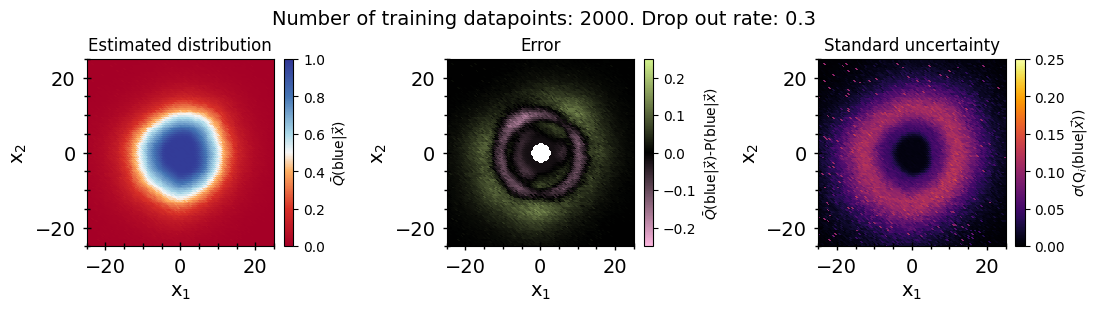

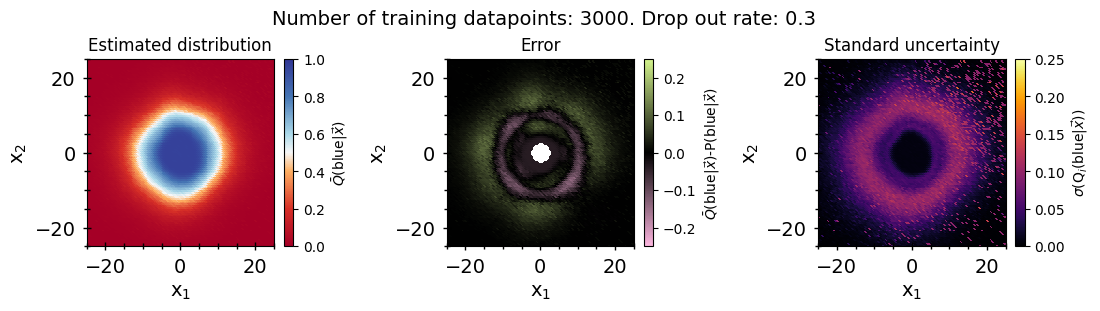

In [37]:
for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (11,3), layout="constrained")
    axs[0] = plot_results(grid_dfs[i], "Confidence_MC", axs[0], "Estimated distribution", grid=True)
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=red_blue_cmap()), fraction=0.050, pad=0.04, 
                 label=r"$\bar{Q}$(blue|$\vec{x}$)", ax=axs[0])

    axs[1] = plot_diff(grid_dfs[i], truth_data, "Confidence_MC", "P_blue_given_x", axs[1], r"Error", max_val = max_err_val[i])
    hue_norm = mpl.colors.Normalize(vmin=-max_err_val[i], vmax=max_err_val[i], clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=pink_black_green_cmap()), fraction=0.050, pad=0.04, 
                 label=r"$\bar{Q}$(blue|$\vec{x}$)-P(blue|$\vec{x}$)", ax=axs[1])

    axs[2] = plot_std(grid_dfs[i], "Std_MC", axs[2], "Standard uncertainty", grid=True, max_val = max_err_val[i])
    
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=max_err_val[i], clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap="inferno"), fraction=0.050, pad=0.04, 
                 label=r"$\sigma$(Q$_i$(blue|$\vec{x}$))", ax=axs[2])

    #fig.savefig(f"../fig/MCD_ntrain_{n_data[i]}.pdf", format="pdf", bbox_inches='tight', dpi=350)
    fig.suptitle(f"Number of training datapoints: {n_data[i]}. Drop out rate: {drop_out_rate}", fontsize=14)

In [22]:
scores = calculate_metrics(test_dfs, grid_dfs, n_data, truth_data, truth_test_data, 
                           "Prediction_MC", "Confidence_MC", "Std_MC")
print(scores)

test_dfs_small = [df[0:1000] for df in test_dfs]
scores_small = calculate_metrics(test_dfs_small, grid_dfs, n_data, truth_data, truth_test_data, 
                           "Prediction_MC", "Confidence_MC", "Std_MC")
print(scores - scores_small)

   N data     ACC    ROCAUC   WD test   WD grid    Avg UE    Std UE  \
0     250  0.6844  0.774025  0.063505  0.079932  0.105108  0.031090   
1     500  0.7227  0.804715  0.072498  0.084378  0.117341  0.028702   
2    1000  0.7283  0.811659  0.059972  0.057420  0.092739  0.032683   
3    5000  0.7424  0.820744  0.030134  0.022984  0.065343  0.024528   
4   10000  0.7420  0.821300  0.020898  0.015220  0.053769  0.023012   

   Mean KL-div test  Mean KL-div grid   LogLoss       ECE       MCE     RMSCE  
0          0.038569          0.059339  0.566775  0.045426  0.103640  0.051476  
1          0.028092          0.050058  0.547356  0.058701  0.131136  0.070082  
2          0.022036          0.025594  0.535737  0.057468  0.108071  0.062904  
3          0.014106          0.003841  0.514312  0.031933  0.072920  0.037786  
4          0.013623          0.001637  0.510466  0.022142  0.059394  0.027974  
   N data     ACC    ROCAUC   WD test  WD grid    Avg UE    Std UE  \
0       0 -0.0086 -0.01

### Results for MC dropout during training only

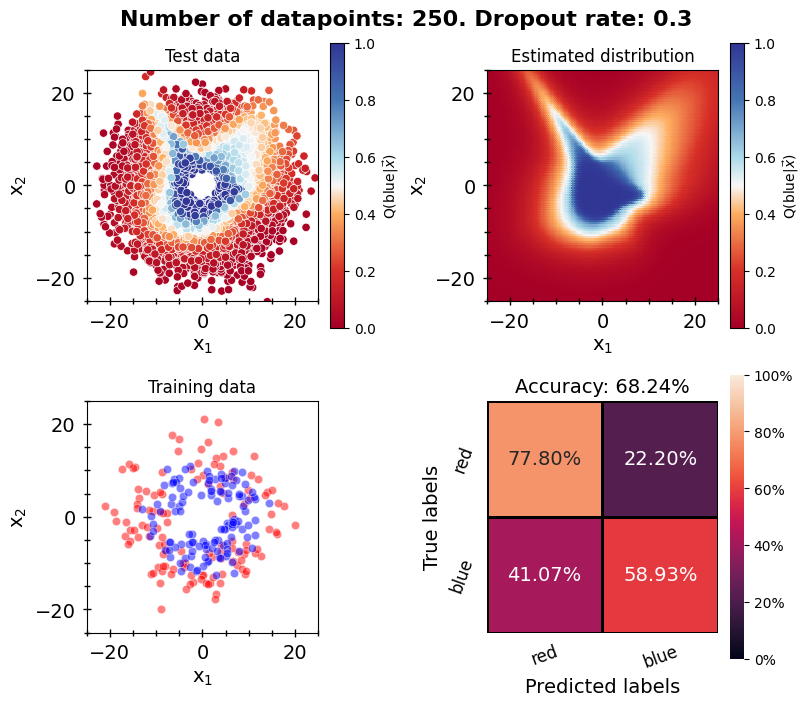

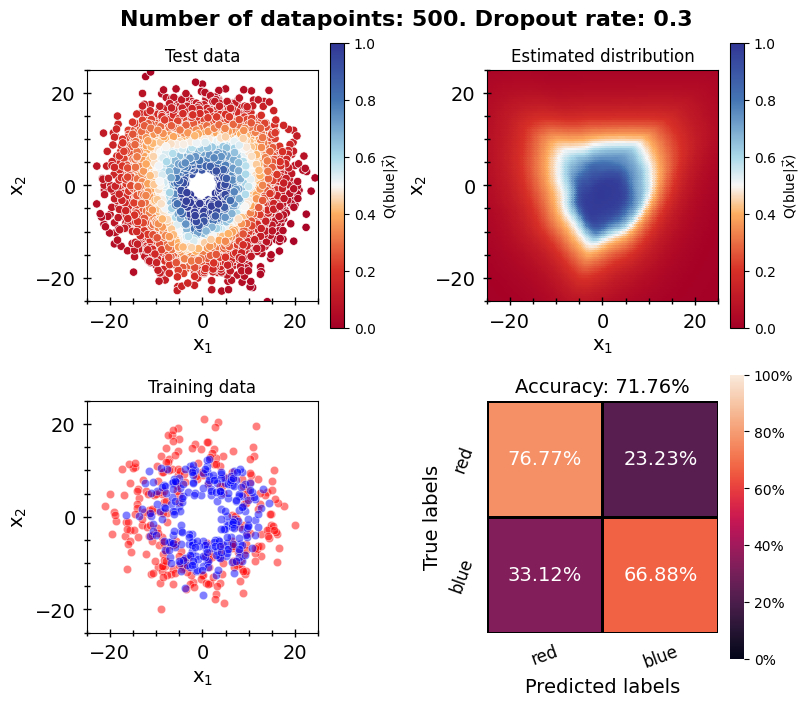

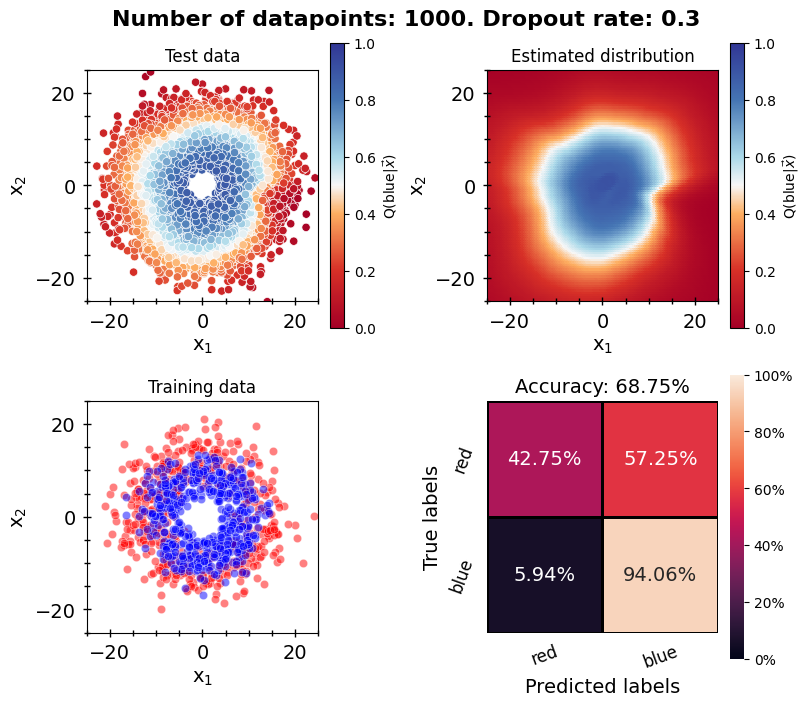

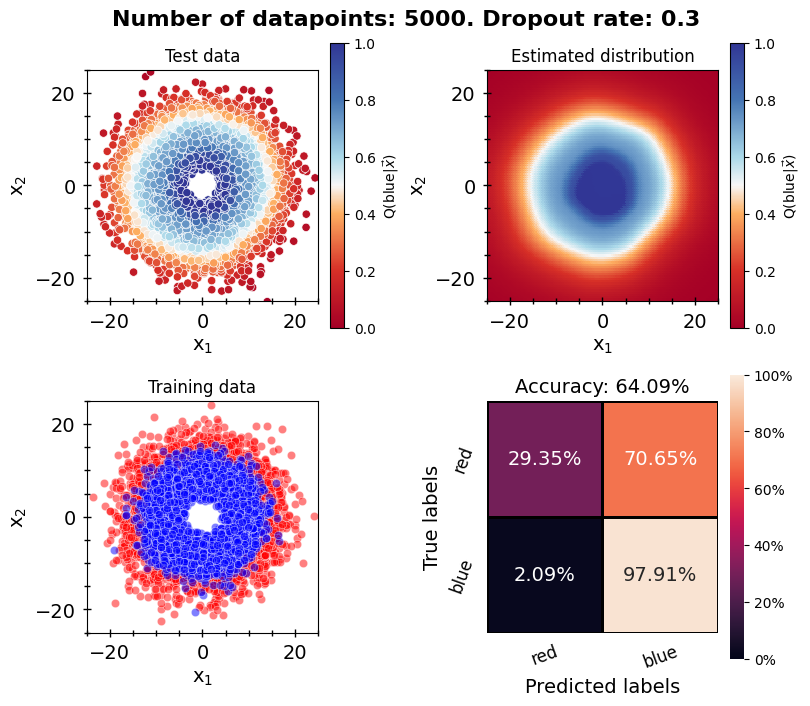

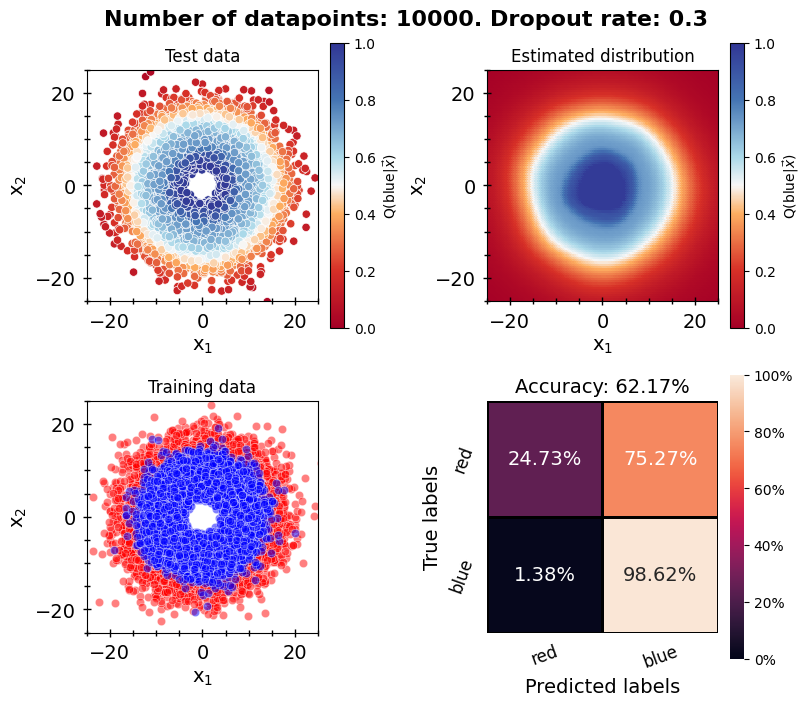

In [23]:

for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 7), layout="constrained")

    axs[0][0] = plot_results(test_dfs[i], "Confidence", axs[0][0], "Test data")
    axs[0][1] = plot_grid(grid_dfs[i], "Confidence", axs[0][1], "Estimated distribution")
    axs[1][1] = plot_conf_matrix(test_dfs[i], "class", "Prediction", ["red", "blue"], axs[1][1])
    axs[1][0] = plot_data(train_data[0:n_data[i]], axs[1][0], "Training data")

    cmap = red_blue_cmap()
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][0])
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][1])

    fig.suptitle(f"Number of datapoints: {n_data[i]}. Dropout rate: {drop_out_rate}", size=16, fontweight="bold")

### Plot MC dropout during training and inference results

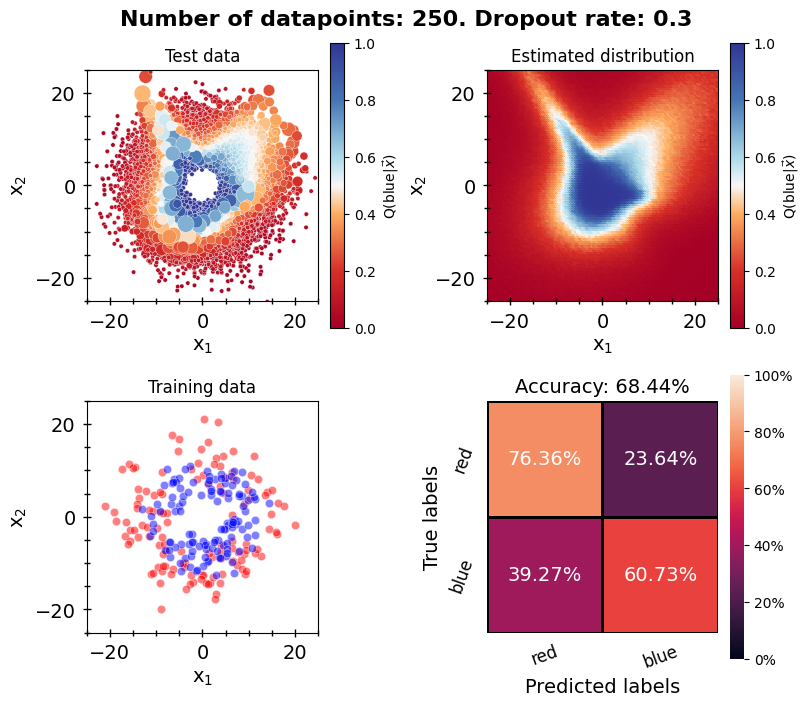

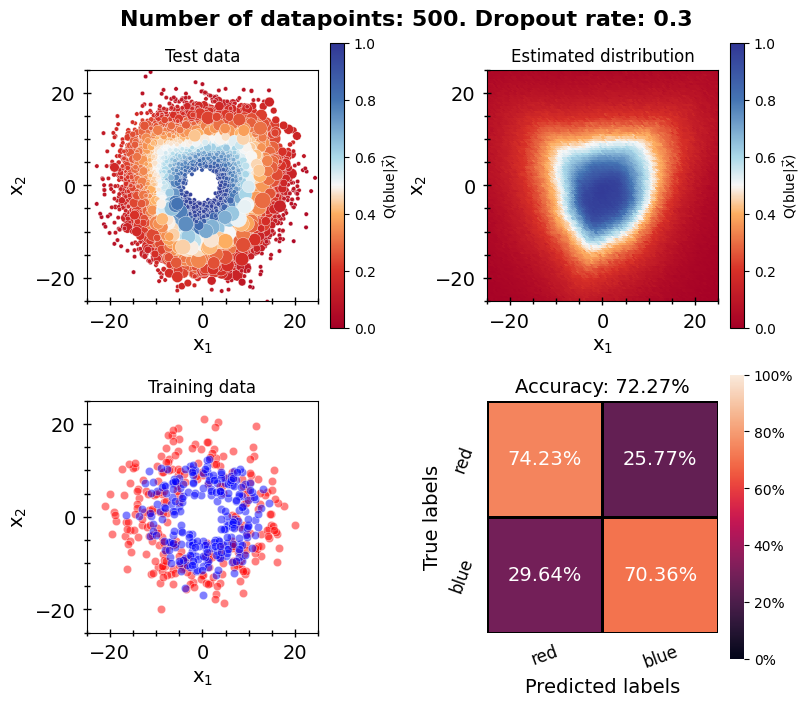

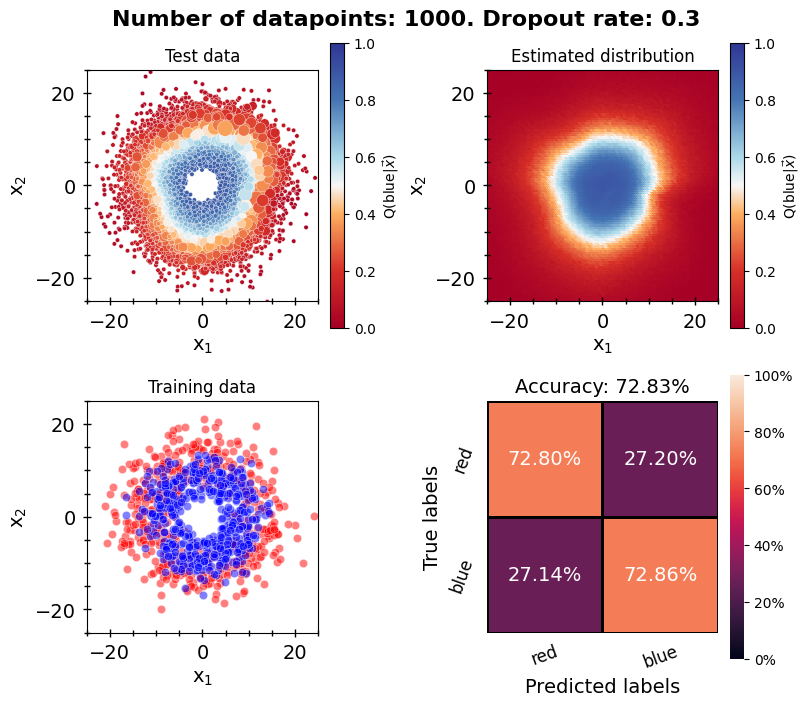

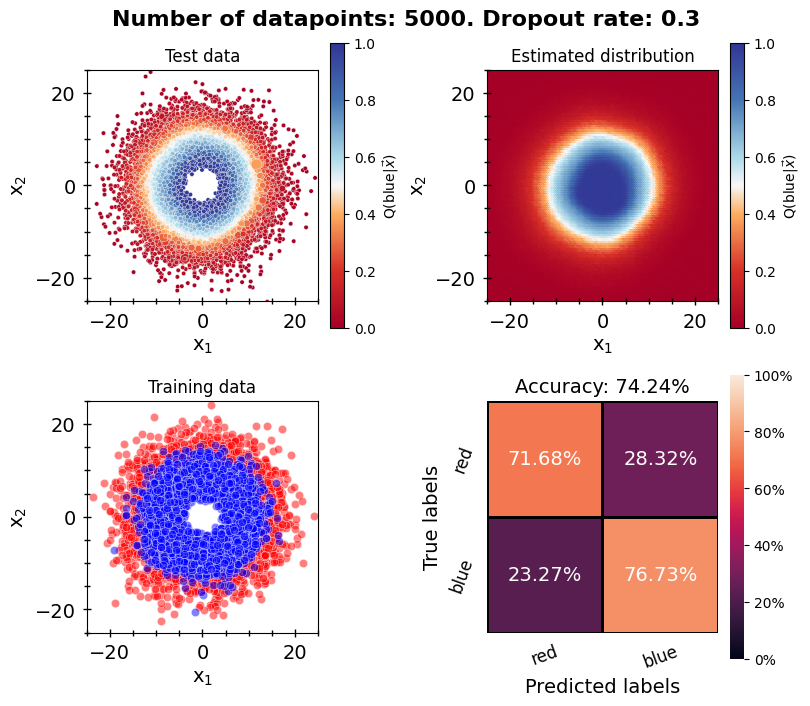

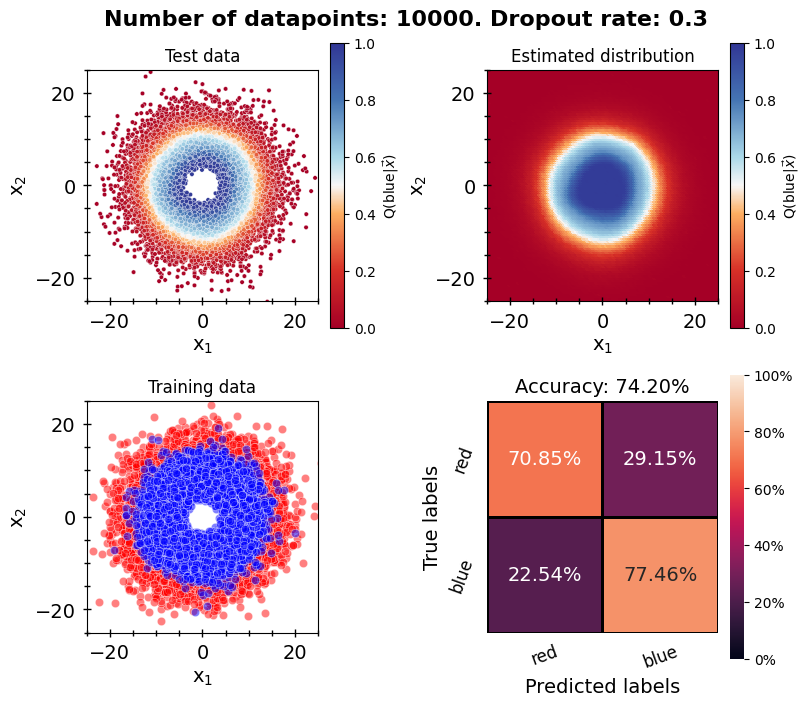

In [24]:
# Plot
for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 7), layout="constrained")

    axs[0][0] = plot_results(test_dfs[i], "Confidence_MC", axs[0][0], "Test data", error_key="Std_MC")
    axs[0][1] = plot_grid(grid_dfs[i], "Confidence_MC", axs[0][1], "Estimated distribution")
    axs[1][1] = plot_conf_matrix(test_dfs[i], "class", "Prediction_MC", ["red", "blue"], axs[1][1])
    axs[1][0] = plot_data(train_data[0:n_data[i]], axs[1][0], "Training data")

    cmap = red_blue_cmap()
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][0])
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][1])

    fig.suptitle(f"Number of datapoints: {n_data[i]}. Dropout rate: {drop_out_rate}", size=16, fontweight="bold")


In [14]:
test_data

color         x1         x2        a1        a2         r1  r2  \
0      red   4.637181  11.350187  0.935784  1.553757  11.837233   3   
1      red  10.042744  10.382106  0.682262  0.612850  11.887063   3   
2     blue  -5.605532  11.920284  1.943990  0.295500  10.273541   3   
3     blue  -1.477669 -14.679668  4.577589  0.170343  11.788505   3   
4     blue  -9.945727   8.379890  2.213879  1.781017  13.296149   3   
...    ...        ...        ...       ...       ...        ...  ..   
9995   red   0.596807   9.253463  1.318706  2.526894  11.560692   3   
9996  blue  -6.404741   6.863661  1.997287  1.496279   8.674995   3   
9997  blue -11.277142   2.093363  2.757517  0.865739   9.295702   3   
9998   red   8.927445  11.836816  0.898653  3.012991  17.796208   3   
9999  blue  -3.594322  -8.356490  4.193690  2.794252  11.860049   3   

            r_x       a_x  class  
0     12.260921  1.182936      0  
1     14.444543  0.802012      0  
2     13.172515  2.010363      1  
3     14.753853  4.612066      1  
4     13.005386  2.441433      1  
...         ...       ...    ...  
9995   9.272689  1.506390      0  
9996   9.387787  2.321621      1  
9997  11.469791  2.958053      1  
9998  14.825974  0.924606      0  
9999   9.096707  4.306187      1  

[10000 rows x 10 columns]

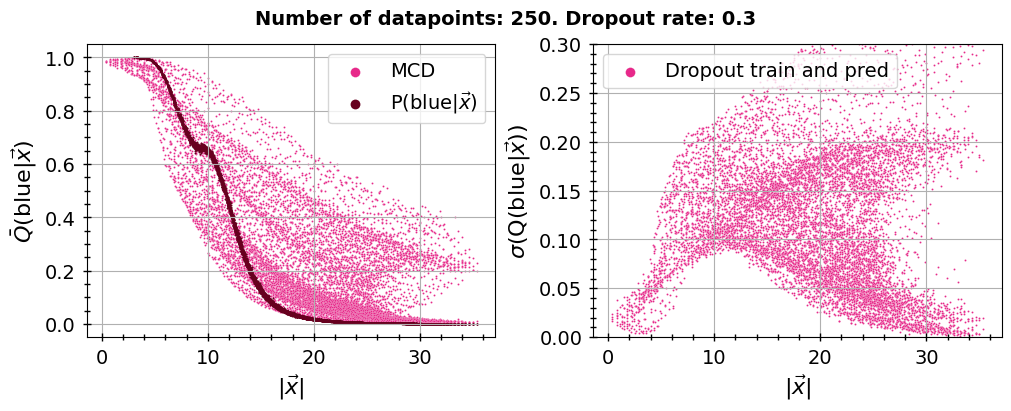

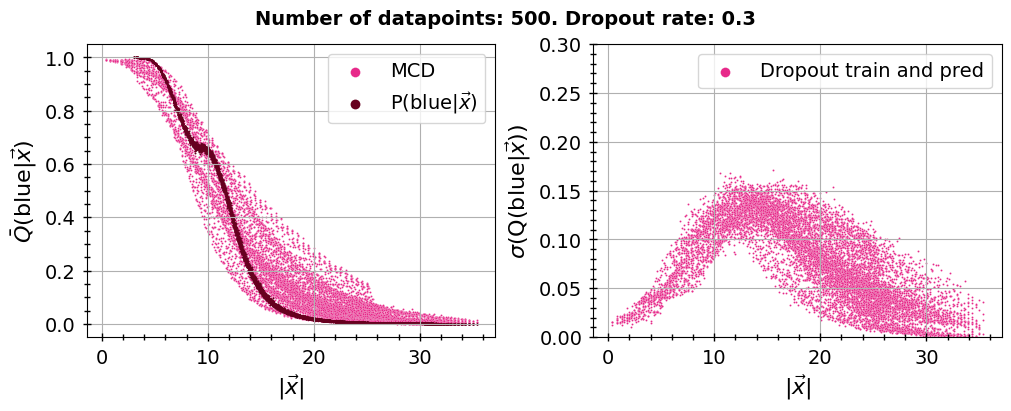

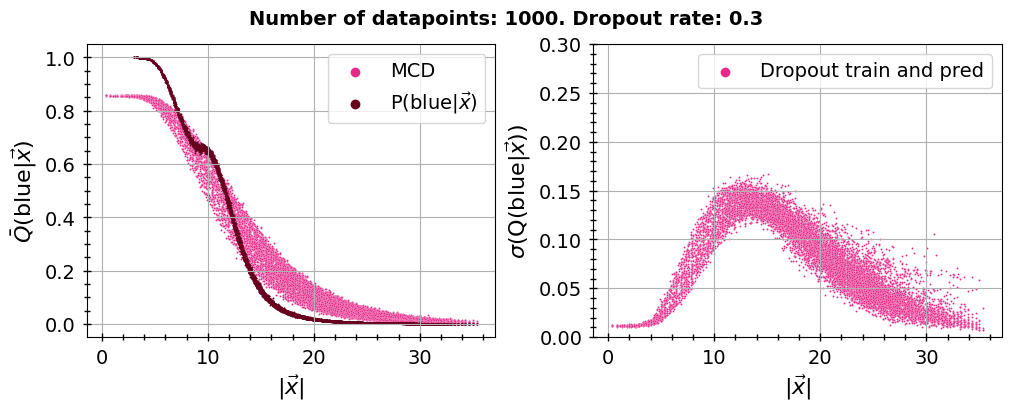

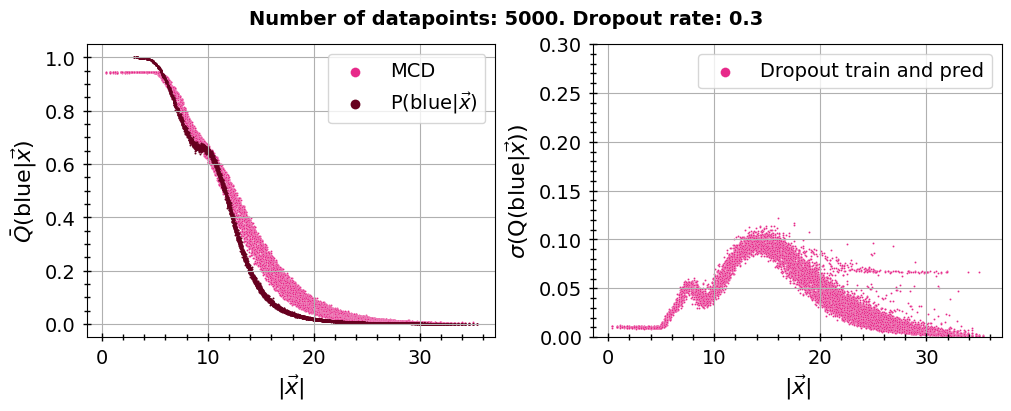

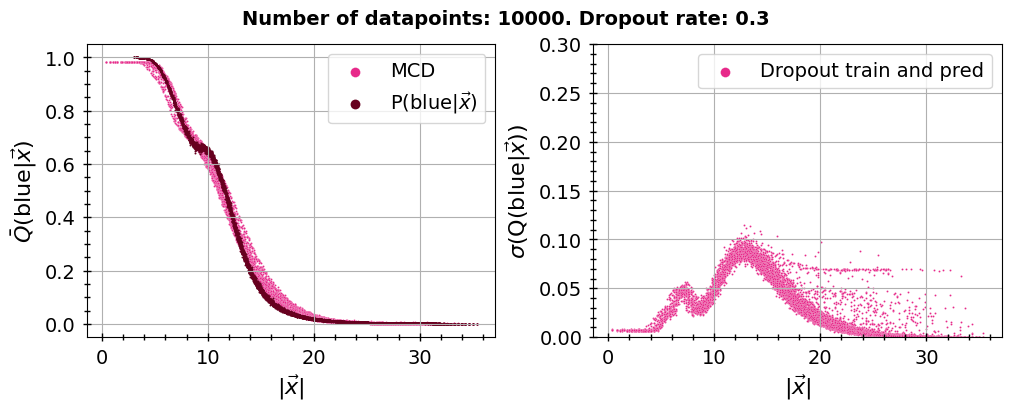

In [19]:
for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
    sn.scatterplot(grid_dfs[i], x="r_x", y="Confidence_MC", s=2, ax = axs[0], label="MCD", color="#e7298a")
    #sn.scatterplot(grid_dfs[i], x="r_x", y="Confidence_MC", s=2, ax = axs[0], label="Dropout train and pred", color="#762a83")
    sn.scatterplot(truth_data, x="r_x", y="P_blue_given_x", s=2, ax = axs[0], label=r"P(blue|$\vec{x}$)", color="#67001f", linewidth=0)
    axs[0].set_ylabel(r"$\bar{Q}$(blue|$\vec{x}$)", fontsize=16)

    sn.scatterplot(grid_dfs[i], x="r_x", y="Std_MC", s=2, ax = axs[1], label="Dropout train and pred", color="#e7298a")
    axs[1].set_ylabel(r"$\sigma$(Q(blue|$\vec{x}$))", fontsize=16)
    axs[1].set_ylim(0, 0.3)

    for ax in axs:
        ax.legend(markerscale=5, fontsize=14)
        ax.set_xlabel(r"$|\vec{x}|$", fontsize=16)
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
        ax.minorticks_on()
        ax.grid()
    fig.suptitle(f"Number of datapoints: {n_data[i]}. Dropout rate: {drop_out_rate}", size=14, fontweight="bold")

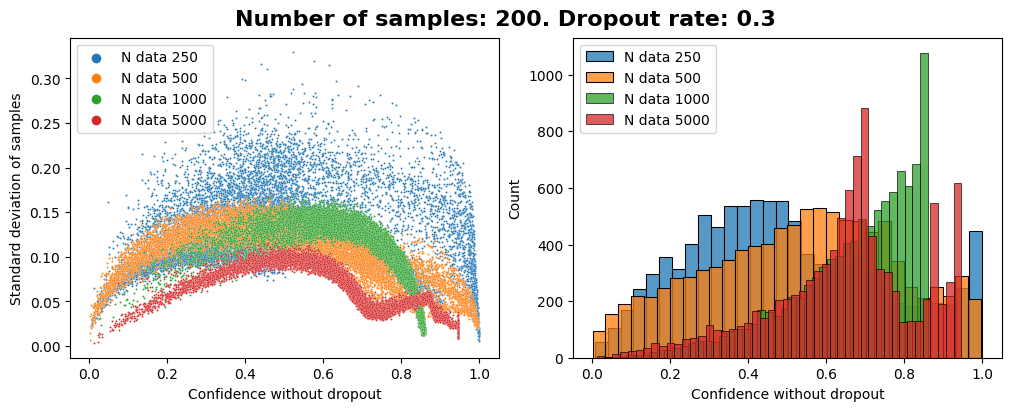

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
for i in range(len(n_data)):
    sn.scatterplot(test_dfs[i], x="Confidence", y=f"Std_MC", s=2, label=f"N data {n_data[i]}", ax = axs[0])
    axs[0].legend(markerscale=5)
    axs[0].set_ylabel("Standard deviation of samples")
    axs[0].set_xlabel("Confidence without dropout")

    sn.histplot(test_dfs[i], x="Confidence", label=f"N data {n_data[i]}", ax = axs[1])
    axs[1].legend(markerscale=5)
    axs[1].set_ylabel("Count")
    axs[1].set_xlabel("Confidence without dropout")
    fig.suptitle(f"Number of samples: {200}. Dropout rate: {drop_out_rate}", size=16, fontweight="bold")

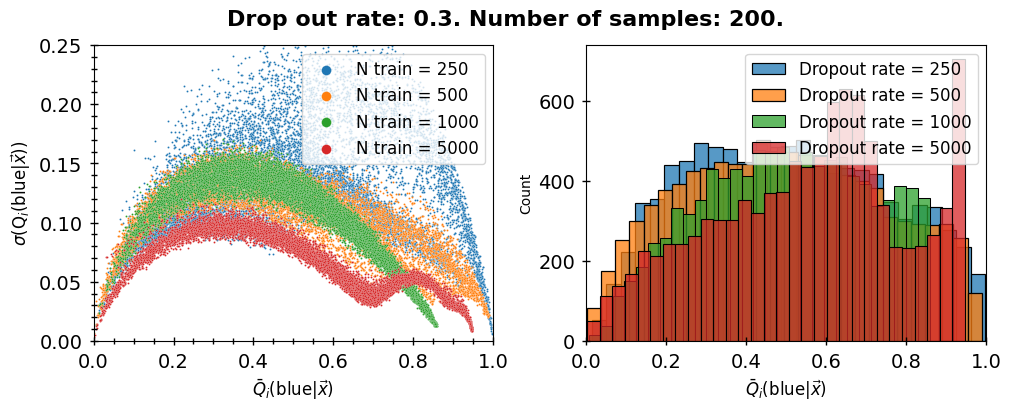

In [24]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
for i in range(len(n_data)):
    sn.scatterplot(test_dfs[i], x="Confidence_MC", y="Std_MC", s=2, label=f"N train = {n_data[i]}", ax = axs[0])
    axs[0].legend(markerscale=5, fontsize=12)
    axs[0].set_ylabel(r"$\sigma$(Q$_i$(blue|$\vec{x}$))", fontsize=12)
    axs[0].set_xlabel(r"$\bar{Q}_i$(blue|$\vec{x}$)", fontsize=12)
    axs[0].set_xlim(0, 1)
    axs[0].set_ylim(0, 0.25)
    sn.histplot(test_dfs[i], x="Confidence_MC", label=f"Dropout rate = {n_data[i]}", ax = axs[1])
    axs[1].legend(markerscale=5, fontsize=12)
    axs[1].set_ylabel("Count")
    axs[1].set_xlabel(r"$\bar{Q}_i$(blue|$\vec{x}$)", fontsize=12)
    axs[1].set_xlim(0, 1)
    for ax in axs:
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
    axs[0].minorticks_on()
    fig.suptitle(f"Drop out rate: {drop_out_rate}. Number of samples: {n_MC}.", size=16, fontweight="bold")

### Try different drop out rates

In [30]:

#p_drop_out = [0.1, 0.2, 0.3, 0.4, 0.5]
p_drop_out = [0.1, 0.2, 0.3, 0.4, 0.5]
n_train = 5000
n_MC=200
test_dfs_DO = [0]*len(p_drop_out)
grid_dfs_DO = [0]*len(p_drop_out)

if load_values==False:
    for i in range(len(p_drop_out)):
        grid_dfs_DO[i] = pd.read_csv(f"../data/{gridfile}.csv")
        test_dfs_DO[i] = pd.read_csv(f"../data/{testfile}.csv")
        # Create datasets for pytorch
        train_dataset = torch.utils.data.TensorDataset(X_train[0:n_train], Y_train[0:n_train])

        # Create model
        model = SequentialNet(L=1024*2, n_hidden=5, activation="relu", in_channels=2, out_channels=2, p=p_drop_out[i]).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Train model
        training_results = train_classifier(model, train_dataset, 
                                val_dataset, batchsize=2**10, epochs = 250, 
                                device = device, optimizer = optimizer, early_stopping=patience)

        # Predict
        test_dfs_DO[i] = predict_MCD(model, test_dfs_DO[i], test_dataset, device, n_MC=n_MC)
        grid_dfs_DO[i] = predict_MCD(model, grid_dfs_DO[i], grid_dataset, device, n_MC=n_MC)

        # Save prediction
        if (not os.path.isdir(f"predictions/{trainfile}") ):
            os.mkdir(f"predictions/{trainfile}")
        test_dfs_DO[i].to_csv(f"predictions/{trainfile}/{testfile}_predicted_SequentialNet_MCD_Vpd{p_drop_out[i]}_nMC_{n_MC}_ndata-{n_train}.csv")
        grid_dfs_DO[i].to_csv(f"predictions/{trainfile}/grid_{tag}_predicted_SequentialNet_MCD_Vpd{p_drop_out[i]}_nMC_{n_MC}_ndata-{n_train}.csv")
else:
    for i in range(len(p_drop_out)):
    #val_data_ensembles = [pd.read_csv(f"predictions/{trainfile}/{valfile}_predicted_SequentialNet_{n_ensemble}ensembles_ndata-{n_data[i]}.csv") for i in range(len(n_data))]
        test_dfs_DO[i] = pd.read_csv(f"predictions/{trainfile}/{testfile}_predicted_SequentialNet_MCD_Vpd{p_drop_out[i]}_nMC_{n_MC}_ndata-{n_train}.csv")
        grid_dfs_DO[i] = pd.read_csv(f"predictions/{trainfile}/grid_{tag}_predicted_SequentialNet_MCD_Vpd{p_drop_out[i]}_nMC_{n_MC}_ndata-{n_train}.csv")

    

In [25]:
for i in range(len(p_drop_out)):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
    sn.scatterplot(grid_dfs_DO[i], x="r_x", y="Confidence", s=2, ax = axs[0], label="Dropout train", color="#e7298a")
    sn.scatterplot(grid_dfs_DO[i], x="r_x", y="Confidence_MC", s=2, ax = axs[0], label="Dropout train and pred", color="#762a83")
    #sn.lineplot(truth_data, x="r_x", y="P_blue_given_x", linewidth=2, ax = axs[0], label="Generating function", color="#67001f")
    axs[0].set_ylabel(r"Q(blue|$\vec{x}$)", fontsize=16)

    sn.scatterplot(grid_dfs_DO[i], x="r_x", y="Std_MC", s=2, ax = axs[1], label="Dropout train and pred", color="#e7298a")
    axs[1].set_ylabel(r"$\sigma$(Q(blue|$\vec{x}$))", fontsize=16)
    axs[1].set_ylim(0, 0.3)

    for ax in axs:
        ax.legend(markerscale=5, fontsize=12)
        ax.set_xlabel(r"$|\vec{x}|$", fontsize=16)
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
        ax.minorticks_on()
        ax.grid()
    fig.suptitle(f"Number of datapoints: {n_train}. Number of samples: {n_MC}. Drop out rate: {p_drop_out[i]}", size=16, fontweight="bold")

NameError: name 'p_drop_out' is not defined

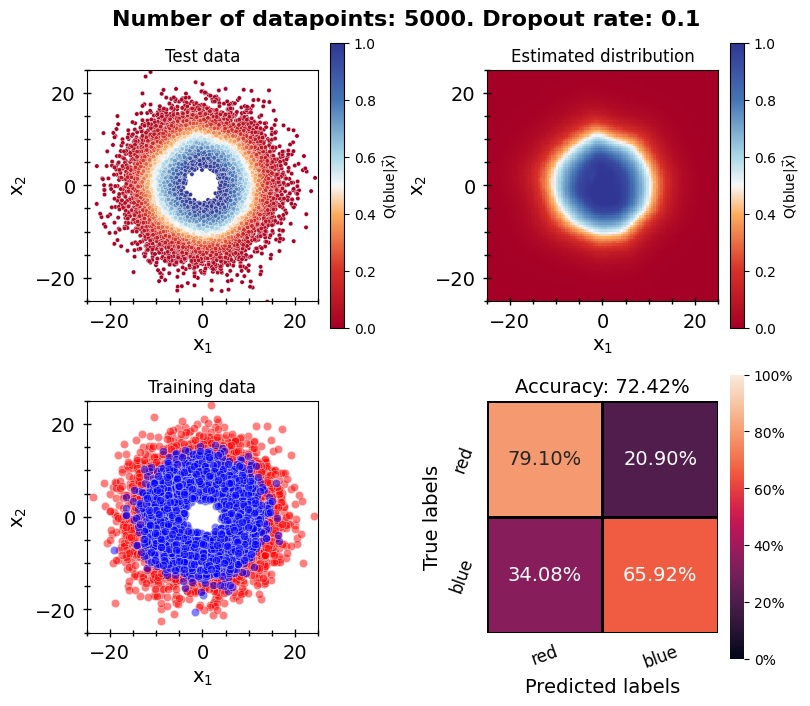

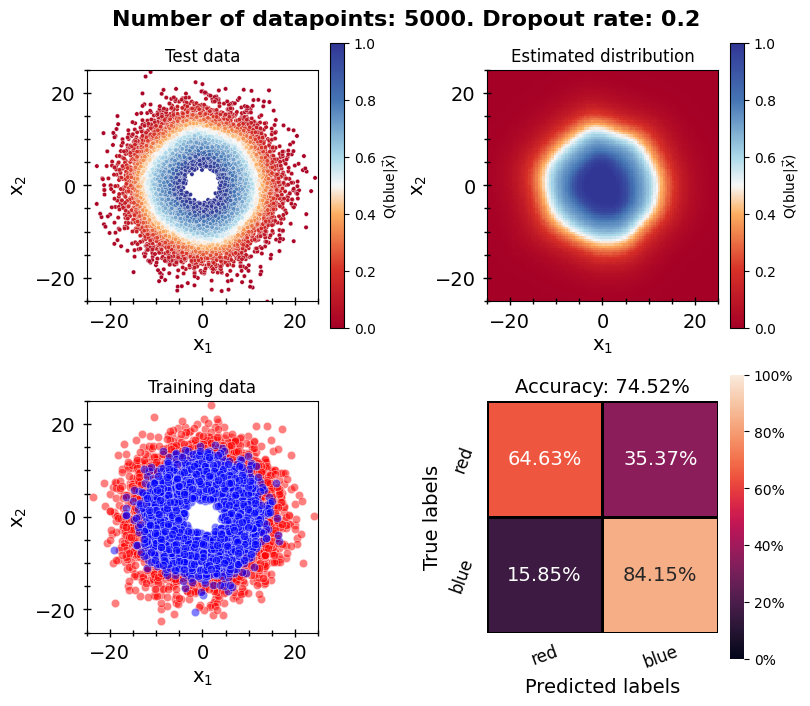

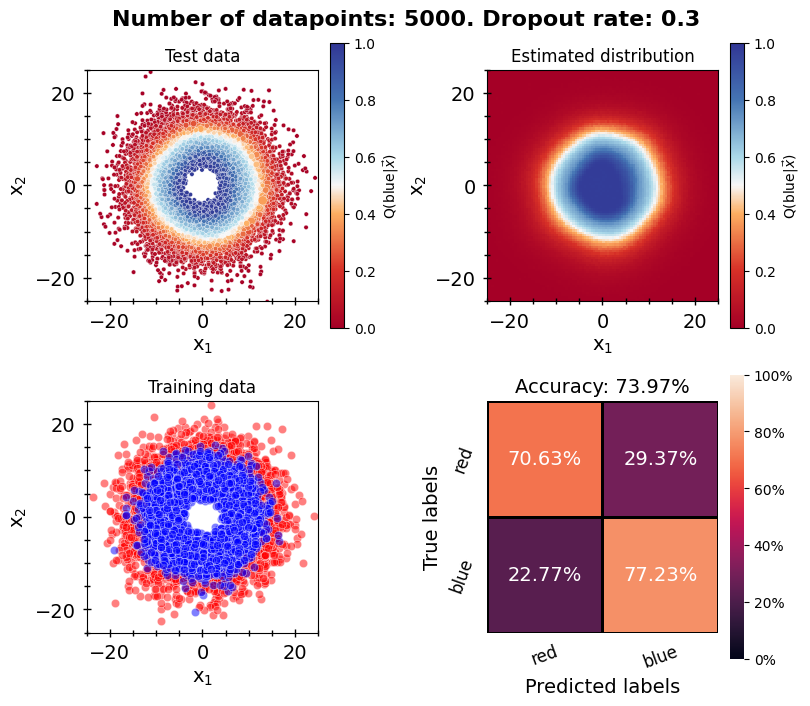

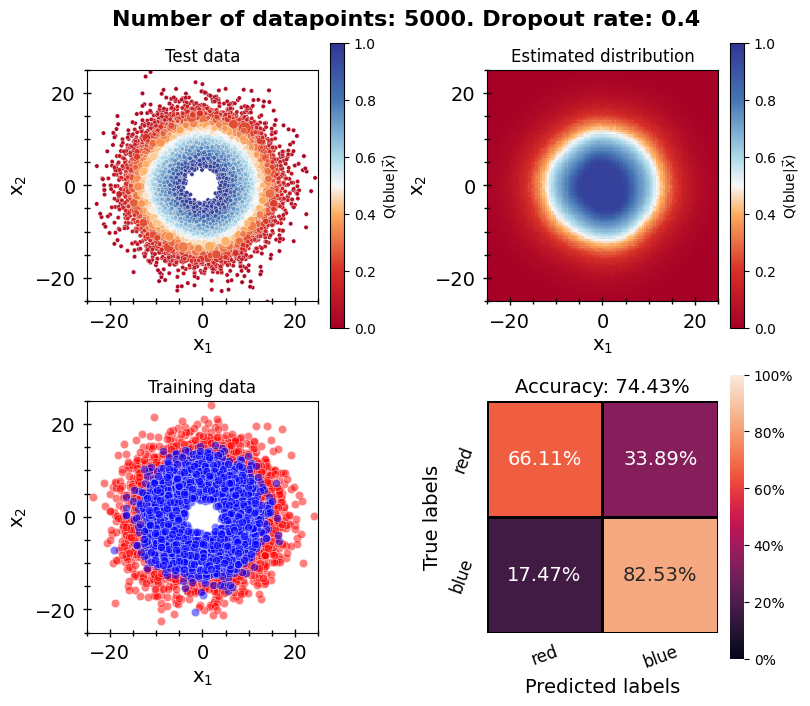

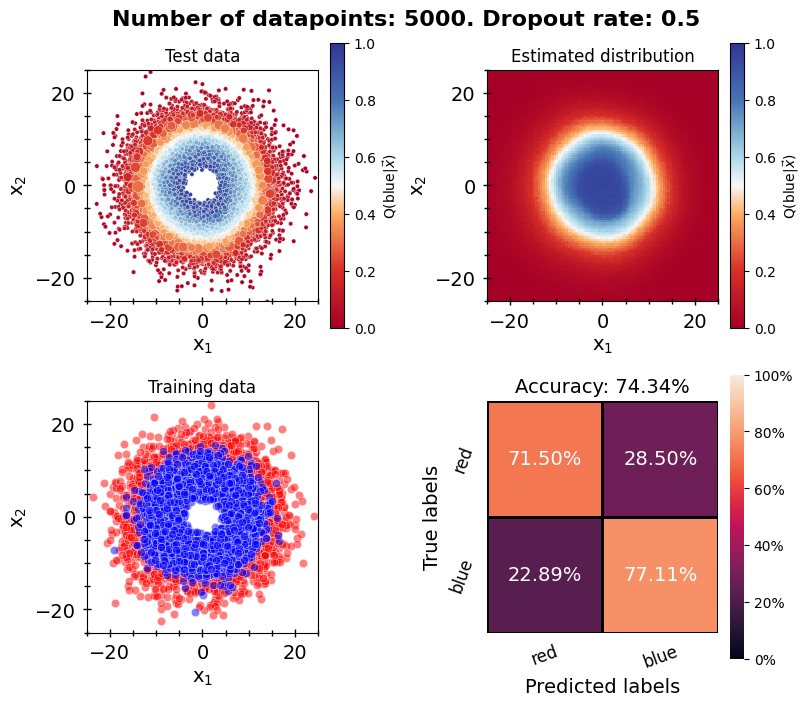

In [32]:
# Plot
for i in range(len(p_drop_out)):
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 7), layout="constrained")

    axs[0][0] = plot_results(test_dfs_DO[i], "Confidence_MC", axs[0][0], "Test data", error_key="Std_MC")
    axs[0][1] = plot_grid(grid_dfs_DO[i], "Confidence_MC", axs[0][1], "Estimated distribution")
    axs[1][1] = plot_conf_matrix(test_dfs_DO[i], "class", "Prediction_MC", ["red", "blue"], axs[1][1])
    axs[1][0] = plot_data(train_data[0:5000], axs[1][0], "Training data")

    cmap = red_blue_cmap()
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][0])
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][1])

    fig.suptitle(f"Number of datapoints: {n_train}. Dropout rate: {p_drop_out[i]}", size=16, fontweight="bold")


### Standard deviation of MC dropout prediction

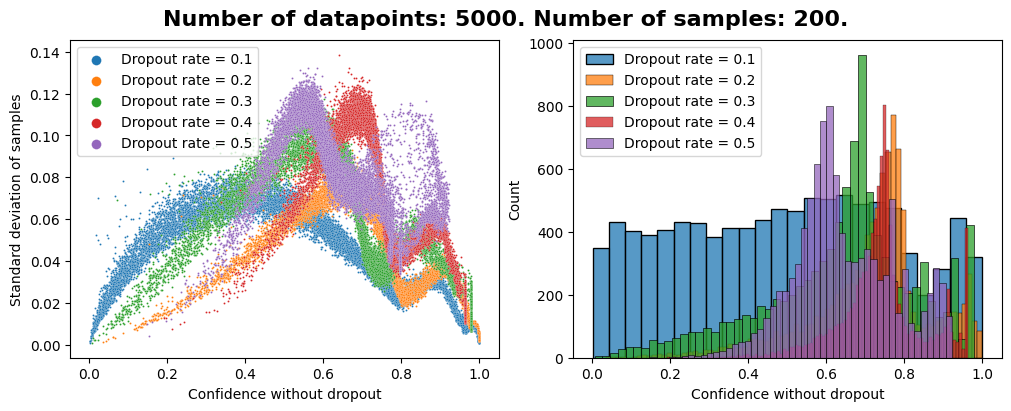

In [33]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
for i in range(len(p_drop_out)):
    sn.scatterplot(test_dfs_DO[i], x="Confidence", y="Std_MC", s=2, label=f"Dropout rate = {p_drop_out[i]}", ax = axs[0])
    axs[0].legend(markerscale=5)
    axs[0].set_ylabel("Standard deviation of samples")
    axs[0].set_xlabel("Confidence without dropout")
    sn.histplot(test_dfs_DO[i], x="Confidence", label=f"Dropout rate = {p_drop_out[i]}", ax = axs[1])
    axs[1].legend(markerscale=5)
    axs[1].set_ylabel("Count")
    axs[1].set_xlabel("Confidence without dropout")
    fig.suptitle(f"Number of datapoints: {n_train}. Number of samples: {n_MC}.", size=16, fontweight="bold")

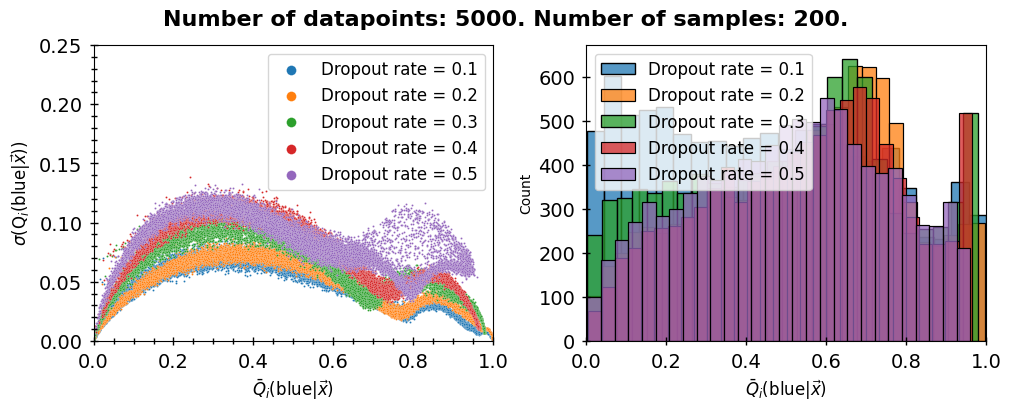

In [34]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
for i in range(len(p_drop_out)):
    sn.scatterplot(test_dfs_DO[i], x="Confidence_MC", y="Std_MC", s=2, label=f"Dropout rate = {p_drop_out[i]}", ax = axs[0])
    axs[0].legend(markerscale=5, fontsize=12)
    axs[0].set_ylabel(r"$\sigma$(Q$_i$(blue|$\vec{x}$))", fontsize=12)
    axs[0].set_xlabel(r"$\bar{Q}_i$(blue|$\vec{x}$)", fontsize=12)
    axs[0].set_xlim(0, 1)
    axs[0].set_ylim(0, 0.25)
    sn.histplot(test_dfs_DO[i], x="Confidence_MC", label=f"Dropout rate = {p_drop_out[i]}", ax = axs[1])
    axs[1].legend(markerscale=5, fontsize=12)
    axs[1].set_ylabel("Count")
    axs[1].set_xlabel(r"$\bar{Q}_i$(blue|$\vec{x}$)", fontsize=12)
    axs[1].set_xlim(0, 1)
    for ax in axs:
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
    axs[0].minorticks_on()
    fig.suptitle(f"Number of datapoints: {n_train}. Number of samples: {n_MC}.", size=16, fontweight="bold")

In [39]:
n_MC_list = [10, 100, 1000]
n_train = 1000
drop_out_rate = 0.3
test_dfs_nMC = [0]*len(n_data)
grid_dfs_nMC = [0]*len(n_data)

if load_values==False:
    for i in range(len(p_drop_out)):
        grid_dfs_nMC[i] = pd.read_csv(f"../data/{gridfile}.csv")
        test_dfs_nMC[i] = pd.read_csv(f"../data/{testfile}.csv")
        # Create datasets for pytorch
        train_dataset = torch.utils.data.TensorDataset(X_train[0:n_train], Y_train[0:n_train])

        # Create model
        model = SequentialNet(L=1024*2, n_hidden=5, activation="relu", in_channels=2, out_channels=2, p=drop_out_rate).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Train model
        training_results = train_classifier(model, train_dataset, 
                                val_dataset, batchsize=2**10, epochs = 250, 
                                device = device, optimizer = optimizer, early_stopping=patience)

        # Predict
        test_dfs_nMC[i] = predict_MCD(model, test_dfs_nMC[i], test_dataset, device, n_MC=n_MC_list[i])
        grid_dfs_nMC[i] = predict_MCD(model, grid_dfs_nMC[i], grid_dataset, device, n_MC=n_MC_list[i])

        # Save prediction
        if (not os.path.isdir(f"predictions/{trainfile}") ):
            os.mkdir(f"predictions/{trainfile}")
        test_dfs_nMC[i].to_csv(f"predictions/{trainfile}/{testfile}_predicted_SequentialNet_MCD_pd{drop_out_rate}_VnMC_{n_MC_list[i]}_ndata-{n_train}.csv")
        grid_dfs_nMC[i].to_csv(f"predictions/{trainfile}/grid_{tag}_predicted_SequentialNet_MCD_pd{drop_out_rate}_VnMC_{n_MC_list[i]}_ndata-{n_train}.csv")
else:
    for i in range(len(n_MC_list)):
    #val_data_ensembles = [pd.read_csv(f"predictions/{trainfile}/{valfile}_predicted_SequentialNet_{n_ensemble}ensembles_ndata-{n_data[i]}.csv") for i in range(len(n_data))]
        test_dfs_nMC[i] = pd.read_csv(f"predictions/{trainfile}/{testfile}_predicted_SequentialNet_MCD_pd{drop_out_rate}_VnMC_{n_MC_list[i]}_ndata-{n_train}.csv")
        grid_dfs_nMC[i] = pd.read_csv(f"predictions/{trainfile}/grid_{tag}_predicted_SequentialNet_MCD_pd{drop_out_rate}_VnMC_{n_MC_list[i]}_ndata-{n_train}.csv")

    

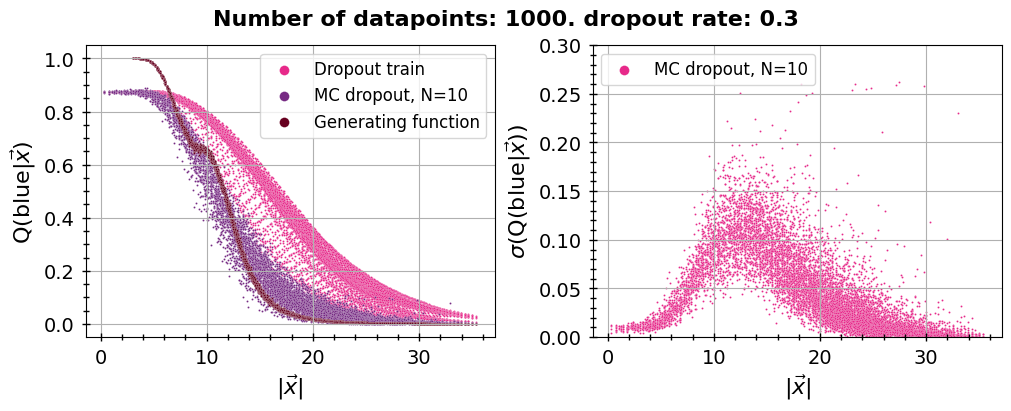

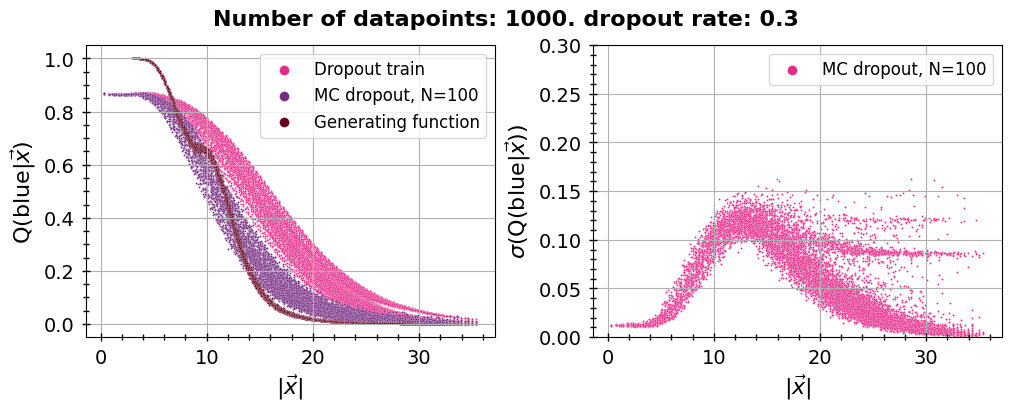

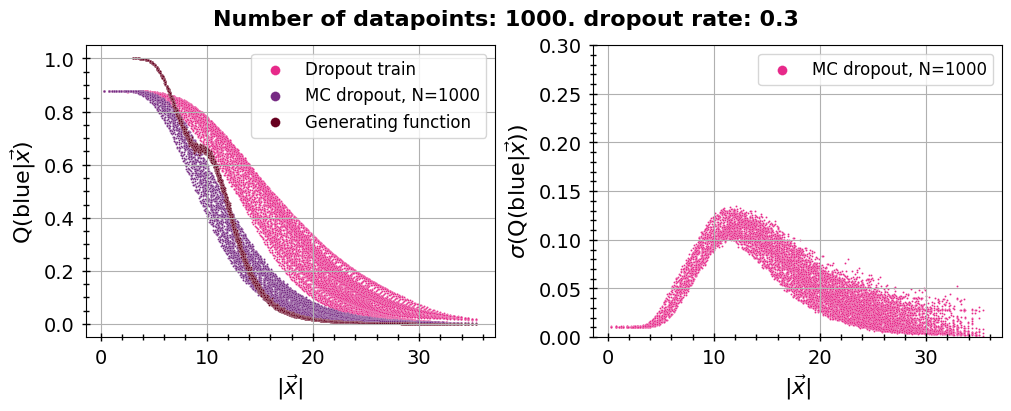

In [41]:

for i in range(len(n_MC_list)):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
    sn.scatterplot(grid_dfs_nMC[i], x="r_x", y=f"Confidence", s=2, ax = axs[0], label="Dropout train", color="#e7298a")
    sn.scatterplot(grid_dfs_nMC[i], x="r_x", y=f"Confidence_MC", s=2, ax = axs[0], label=f"MC dropout, N={n_MC_list[i]}", color="#762a83")
    sn.scatterplot(truth_data, x="r_x", y="P_blue_given_x", s=2, ax = axs[0], label="Generating function", color="#67001f")
    axs[0].set_ylabel(r"Q(blue|$\vec{x}$)", fontsize=16)

    sn.scatterplot(grid_dfs_nMC[i], x="r_x", y=f"Std_MC", s=2, ax = axs[1], label=f"MC dropout, N={n_MC_list[i]}", color="#e7298a")
    axs[1].set_ylabel(r"$\sigma$(Q(blue|$\vec{x}$))", fontsize=16)
    axs[1].set_ylim(0, 0.3)

    for ax in axs:
        ax.legend(markerscale=5, fontsize=12)
        ax.set_xlabel(r"$|\vec{x}|$", fontsize=16)
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
        ax.minorticks_on()
        ax.grid()
    fig.suptitle(f"Number of datapoints: {n_train}. dropout rate: {drop_out_rate}", size=16, fontweight="bold")

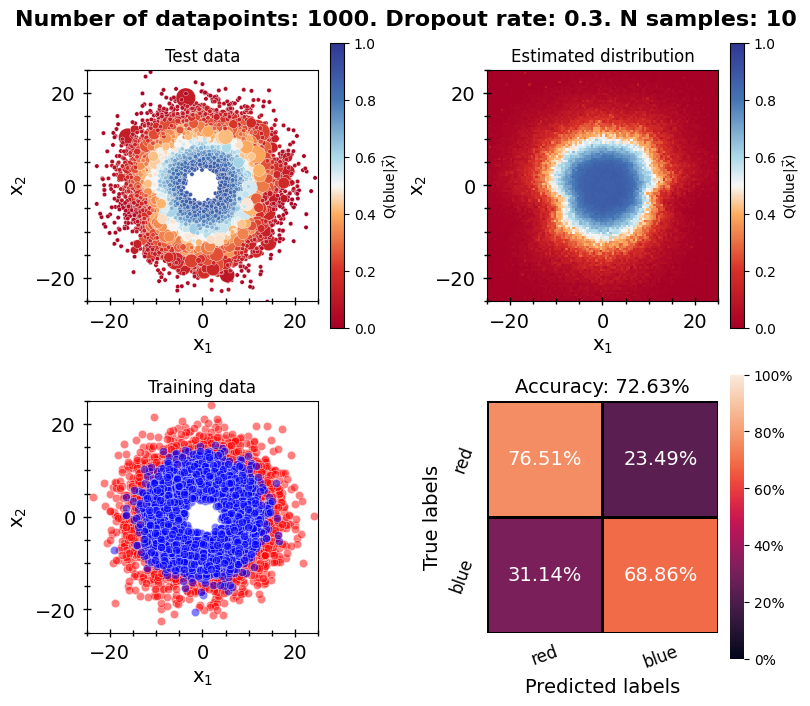

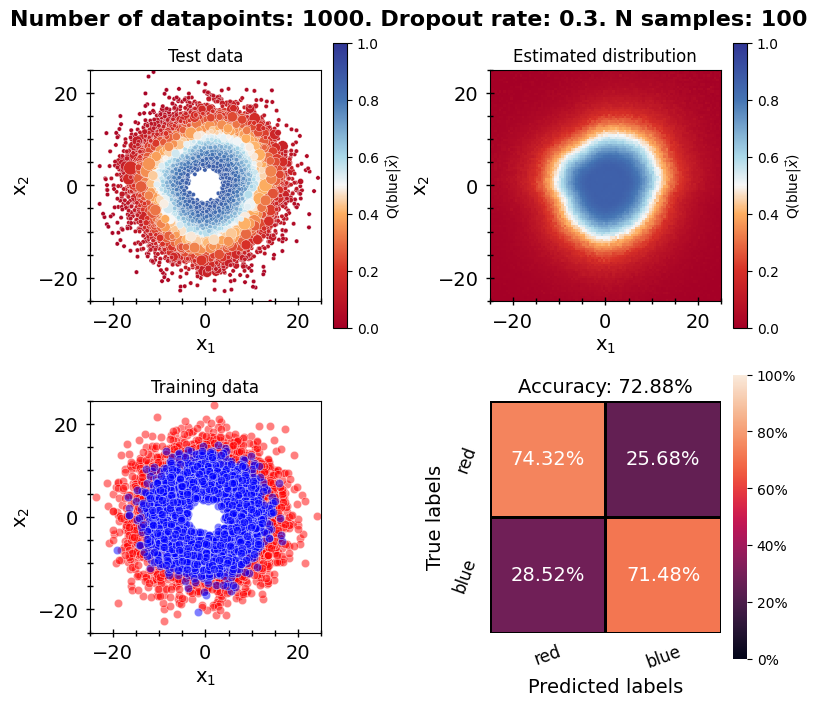

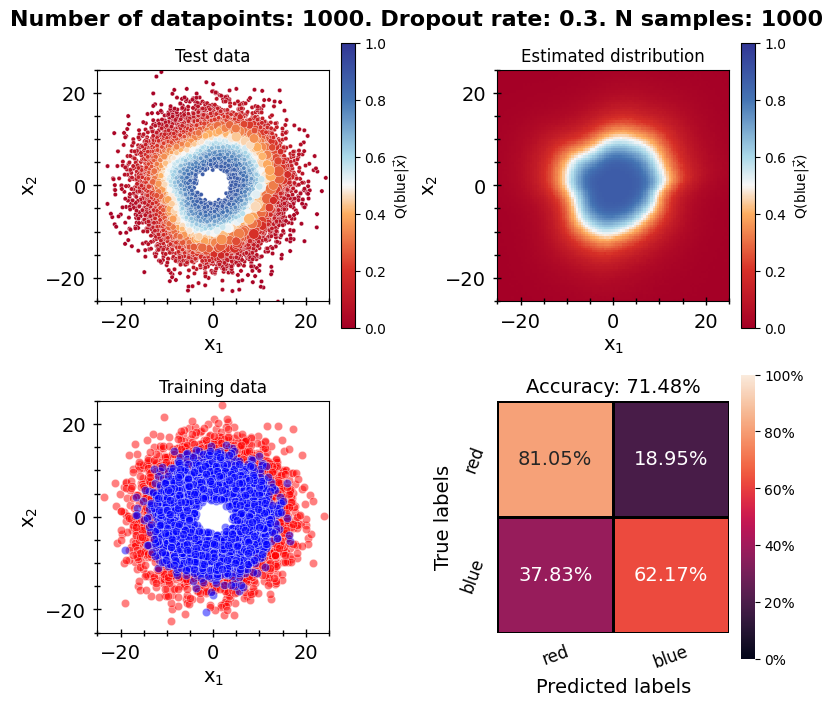

In [42]:
# Plot
for i in range(len(n_MC_list)):
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 7), layout="constrained")

    axs[0][0] = plot_results(test_dfs_nMC[i], f"Confidence_MC", axs[0][0], "Test data", error_key=f"Std_MC")
    axs[0][1] = plot_grid(grid_dfs_nMC[i], f"Confidence_MC", axs[0][1], "Estimated distribution")
    axs[1][1] = plot_conf_matrix(test_dfs_nMC[i], "class", f"Prediction_MC", ["red", "blue"], axs[1][1])
    axs[1][0] = plot_data(train_data[0:5000], axs[1][0], "Training data")

    cmap = red_blue_cmap()
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][0])
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][1])

    fig.suptitle(f"Number of datapoints: {n_train}. Dropout rate: {drop_out_rate}. N samples: {n_MC_list[i]}", size=16, fontweight="bold")


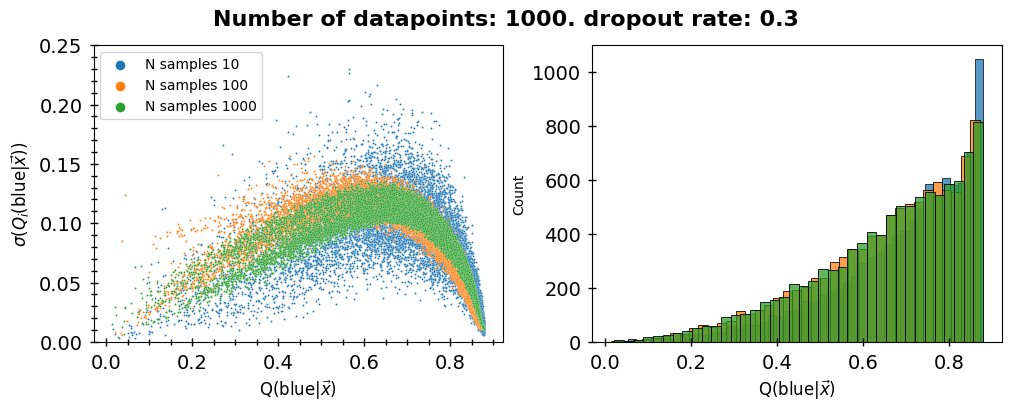

In [43]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
for i in range(len(n_MC_list)):
    sn.scatterplot(test_dfs_nMC[i], x="Confidence", y=f"Std_MC", s=2, label=f"N samples {n_MC_list[i]}", ax = axs[0])
    axs[0].legend(markerscale=5)
    axs[0].set_ylabel(r"$\sigma$($Q_i$(blue|$\vec{x}$))", fontsize=12)
    axs[0].set_xlabel(r"Q(blue|$\vec{x}$)", fontsize=12)
    axs[0].set_ylim(0, 0.25)

    sn.histplot(test_dfs_nMC[i], x="Confidence", ax = axs[1])
    axs[1].set_ylabel("Count")
    axs[1].set_xlabel(r"Q(blue|$\vec{x}$)", fontsize=12)

    for ax in axs:
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
    axs[0].minorticks_on()
    fig.suptitle(f"Number of datapoints: {n_train}. dropout rate: {drop_out_rate}", size=16, fontweight="bold")

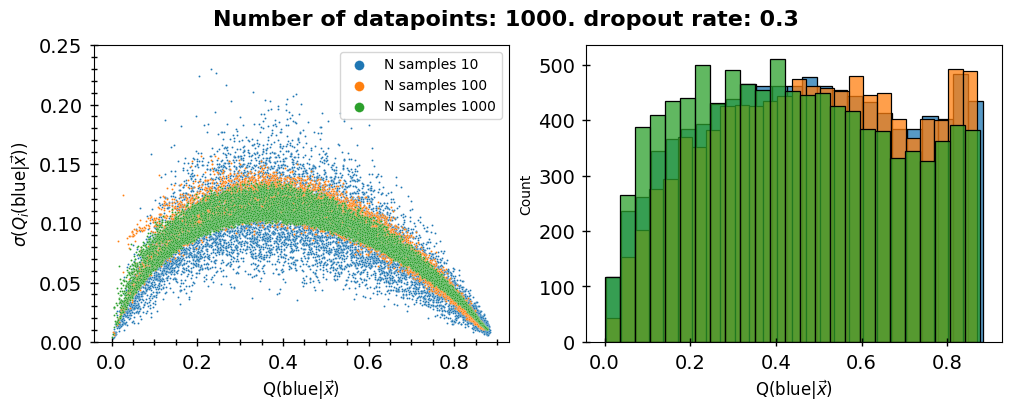

In [44]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
for i in range(len(n_MC_list)):
    sn.scatterplot(test_dfs_nMC[i], x="Confidence_MC", y=f"Std_MC", s=2, label=f"N samples {n_MC_list[i]}", ax = axs[0])
    axs[0].legend(markerscale=5)
    axs[0].set_ylabel(r"$\sigma$($Q_i$(blue|$\vec{x}$))", fontsize=12)
    axs[0].set_xlabel(r"Q(blue|$\vec{x}$)", fontsize=12)
    axs[0].set_ylim(0, 0.25)

    sn.histplot(test_dfs_nMC[i], x="Confidence_MC", ax = axs[1])
    axs[1].set_ylabel("Count")
    axs[1].set_xlabel(r"Q(blue|$\vec{x}$)", fontsize=12)

    for ax in axs:
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
    axs[0].minorticks_on()
    fig.suptitle(f"Number of datapoints: {n_train}. dropout rate: {drop_out_rate}", size=16, fontweight="bold")